# Introduction

The purpose of this document is to illustrate the capabilities in the population simulation toolbox written in python.  The toolbox is a python class object in popsim.py that has numerous functions to aid in simulating population data for IEM.  Let us start by importing the toolbox from popsim.py:

In [1]:
from popsim import Toolbox

The toolbox class contains a number of functions that allow us to adjust the correlation between data features and the autocorrelation between a time series of data sets.  In this demonstration, we will use the toolbox to:
1. Generate an uncorrelated data set to act as a seed for further data manipulation
2. Create a new data set with autocorrelations representing a change from time step 0 to time step 1
3. Change a data set's correlation between features
4. Generate copula data from a correlated data seed

For use in these demonstrations, let us create a toolbox object:

In [2]:
t = Toolbox()

Additionally, let us import some useful python libraries that will help us analyze and visual our demonstrations:

In [3]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import norm

# Demonstrations

## Generating a random, uncorrelated data seed

Arguably, we desire an initial data seed that we can later manipulate as needed.  By generating an initial seed and manipulating it, we know that the first data point in all of our subsequent manipulations correlate to each other, same with the second data point, third data point, and so on.  If we generate two sets of data independently, then the first data points in each set are not correlated, and thus they would not necessarily represent, for example, the same person in an insider threat context.  By creating a seed data set, we initialize each person's data set, and we can control it in a systematic way.

The toolbox's generate_seed() function to create an uncorrelated data sample, $X$, from a multivariate Gaussian distribution such that $X \sim N(\textbf{0}, \textbf{I})$, where $\textbf{0}$ and $\textbf{I}$ are a vector of zeros and an identity matrix of complementary size.  Let us create a seed with 50 features and 1000 data points:

In [4]:
X_seed = t.generate_seed(50,1000)

Let's verify that the seed data has the correct shape.  The number of rows in the data set should be 1000 and the number of columns should be 50 so that the shape should be (1000,50).

In [5]:
print(X_seed.shape)

(1000, 50)


Now, let's verify that the features in the seed data are uncorrelated.  For this, compute the Spearman rank correlation coefficient.  Ideally, the correlation between a feature and itself should be one and the correlation between a feature and another feature should be zero.  Let's see if the diagonal of the correlation matrix consists of all ones:

In [6]:
np.all(np.diag(spearmanr(X_seed)[0])) == True

True

For practicality, we will accept some error in the correlation between different features.  In other words, it is acceptable if the correlation is nonzero as long as the correlation is sufficiently small.  Let's see the maximum absolute correlation in the seed data (not including the self-correlations):

In [7]:
np.max(abs(np.triu(spearmanr(X_seed)[0], 1)))

0.032485412485412486

The maximum allowable correlation error is subjective.  If this error is too large, you may choose to generate another sample.

## Generating an autocorrelated data seed

In the previous demonstration, we generated an uncorrelated data seed.  Now, let's generate another data seed that has a set autocorrelation with the previously generated seed.  We might desire to have two data seeds that have a specific autocorrelation in order to represent data correlation across time steps.  Therefore, if the generate_seed() function in the toolbox creates a data seed for time step 0, the toolbox's time_fit() function transforms that data seed to create a data seed for time step 1.  While this new data seed is correlated to the supplied data seed, the features in the new data seed are uncorrelated.

We use a conditional distribution of a multivariate Gaussian distribution to generate the new data set such that $X_{i,t+1}\,|\,X_{i,t} = x_{i,t} \sim N(\rho_i \times x_{i,t}, (1 - \rho_i^2)\times \mathbf{I})$, where $i$ in the feature index, $t$ is the time step, and $\rho_i$ is the autocorrelation for feature $i$.  Let us generate a new data seed from the original seed with the autocorrelation for every feature as 0.5:

In [8]:
X_step = t.time_fit(X_seed, 0.5*np.ones(50))

Now let's verify that the autocorrelation between a feature in the original data seed and that feature in the new data seed is close to 0.5:

In [9]:
corr = np.zeros(50)
for i in range(50):
    corr[i] = spearmanr(X_seed[:,i],X_step[:,i])[0]
    
print('Max autocorrelation: ' + str(max(corr)))
print('Mean autocorrelation: ' + str(np.mean(corr)))
print('Min autocorrelation: ' + str(min(corr)))

Max autocorrelation: 0.520444516445
Mean autocorrelation: 0.483538548419
Min autocorrelation: 0.441896325896


Now let's check the maximum correlation between features in the new data seed.  Remember, this new data seed should have very little correlation between its features similar to the original, uncorrelated data seed:

In [10]:
np.max(abs(np.triu(spearmanr(X_step)[0], 1)))

0.034162090162090167

Currently, the time_fit() function in the toolbox only supports using one past time step to generate a new data seed.  Future capability will allow for multiple times steps to be used, e.g. using t-2, t-1, and t to generate t+1

## Generating a correlated data seed

In the above demonstrations, we are expliciting keeping features uncorrelated.  Now, let's transform an uncorrelated seed to be correlated.  We accomplish this by using a Cholesky transform on the uncorrelated data seed.  The Cholesky transform uses information from our desired correlation matrix to do linear algebra on the uncorrelated data seed.

Let us generate a correlated data set using our original uncorrelated seed.  We wish our desired correlation between each feature to be 0.75:

In [11]:
sigma = 0.99*np.ones((50,50)) + 0.01*np.eye(50)
X_corr = t.corr_fit(X_seed,sigma)

Now let's verify that the correlations between different features is approximately 0.99:

In [12]:
corr = abs(np.triu(spearmanr(X_corr)[0], 1))
corr = corr[np.nonzero(corr)]
print('Max correlation: ' + str(np.max(corr)))
print('Mean correlation: ' + str(np.mean(corr)))
print('Min correlation: ' + str(np.min(corr)))

Max correlation: 0.990099402099
Mean correlation: 0.989249303137
Min correlation: 0.988514068514


## Generating a copula data seed

Above, we generated a correlated seed data set that is drawn from multivariate Gaussian distribution.  We can transform this correlated data set into a copula data set, i.e. one where the marginal distributions of each feature is uniform.  

In [13]:
X_copula = t.copula_fit(X_corr)

Since we are generating a copula data set from the X_corr data set, we should retain the correlations between the different features encoded in X_corr.  Let's verify that that the correlation of the copula data set is the same as the correlated data set above:

In [14]:
np.all(spearmanr(X_copula)[0] == spearmanr(X_corr)[0])

True

# RCP12 with the Toolbox

Let's now turn out focus specifically to generating answers for RCP12.  In this RCP, we are tasked with predicting the probability of labeling an individual as either a technical staffer, administrive staffer, manager, or student given their actual label.  Let's begin with importing some useful libraries:

In [15]:
from scipy.stats import rv_histogram
from scipy.stats import rv_discrete
from scipy.stats import bernoulli
from sklearn import tree
from sklearn.metrics import confusion_matrix

Now, we import and save the provided histograms for each group as probability objects.  We save Detector 1 as a bernoulli distribution since it can only take a value of 0 and 1, and we save Detectors 3h and 3i as descrete distributions since the provided histograms provide proportions for each integer.  We import the technical staffers' histograms below:

In [16]:
tech = ()
for i,file in enumerate(glob.glob(r'dataFiles\01 Technical Staff\*.csv')):
    data = t.dim_check(np.genfromtxt(file, skip_header = 1, delimiter = ","))
    hist = data[:,2]
    bin_edges = np.append(data[0,0], data[:,1])
    blah = (hist,bin_edges)
    if i == 0:
        p = data[1,2]/np.sum(data[:,2])
        tech = tech + (bernoulli(p),)
    elif i > 9 and i <= 11:
        p = data[:,2]/np.sum(data[:,2])
        x = data[p != 0.,0]
        p = p[p != 0]
        tech = tech + (rv_discrete(values = (x,p)),)
    else:
        tech = tech + (rv_histogram(blah),)

The admin staffer's histograms below:

In [17]:
admin = ()
for i,file in enumerate(glob.glob(r'dataFiles\02 Admins\*.csv')):
    data = t.dim_check(np.genfromtxt(file, skip_header = 1, delimiter = ","))
    hist = data[:,2]
    bin_edges = np.append(data[0,0], data[:,1])
    blah = (hist,bin_edges)
    if i == 0:
        p = data[1,2]/np.sum(data[:,2])
        admin = admin + (bernoulli(p),)
    elif i > 9 and i <= 11:
        p = data[:,2]/np.sum(data[:,2])
        x = data[p != 0.,0]
        p = p[p != 0]
        admin = admin + (rv_discrete(values = (x,p)),)
    else:
        admin = admin + (rv_histogram(blah),)

...and the managers' historgams...

In [18]:
management = ()
for i,file in enumerate(glob.glob(r'dataFiles\03 Management\*.csv')):
    data = t.dim_check(np.genfromtxt(file, skip_header = 1, delimiter = ","))
    hist = data[:,2]
    bin_edges = np.append(data[0,0], data[:,1])
    blah = (hist,bin_edges)
    if i == 0:
        p = data[1,2]/np.sum(data[:,2])
        management = management + (bernoulli(p),)
    elif i > 9 and i <= 11:
        p = data[:,2]/np.sum(data[:,2])
        x = data[p != 0.,0]
        p = p[p != 0]
        management = management + (rv_discrete(values = (x,p)),)
    else:
        management = management + (rv_histogram(blah),)

...and finally the students' histograms:

In [19]:
student = ()
for i,file in enumerate(glob.glob(r'dataFiles\04 Students\*.csv')):
    data = t.dim_check(np.genfromtxt(file, skip_header = 1, delimiter = ","))
    hist = data[:,2]
    bin_edges = np.append(data[0,0], data[:,1])
    blah = (hist,bin_edges)
    if i == 0:
        p = data[1,2]/np.sum(data[:,2])
        student = student + (bernoulli(p),)
    elif i > 9 and i <= 11:
        p = data[:,2]/np.sum(data[:,2])
        x = data[p != 0.,0]
        p = p[p != 0]
        student = student + (rv_discrete(values = (x,p)),)
    else:
        student = student + (rv_histogram(blah),)

With all of this histograms imported and saved, we now generate population seeds for each group:

In [20]:
tech_seed = t.generate_seed(16,1439)
admin_seed = t.generate_seed(16,199)
mgmt_seed = t.generate_seed(16,247)
stud_seed = t.generate_seed(16,10)

We now run a Monte Carlo simulation where we fit the seed populations with random correlation matrices and adjust the marginals according to the imported histograms.  We do this procedure once to generate a training population to train the decision tree classifier then repeat the procedure to generate a test population to generate forecast questions.

In [21]:
Yt = 0*np.ones((1439,1))# Technical
Ya = 1*np.ones((199,1))# Admins
Ym = 2*np.ones((247,1))# Management
Ys = 3*np.ones((10,1))# Students
y = np.concatenate((Yt,Ya,Ym,Ys))

raw = np.zeros((1000,16))*np.nan
for j in range(1000):
    # Training
    df = 16#np.random.randint(16, 1000)
    tech_corr = t.copula_fit(t.corr_fit(tech_seed,t.random_corr_matrix(df,np.eye(16))))
    TechSample = np.zeros(tech_corr.shape)
    for i in range(tech_corr.shape[1]):
        TechSample[:,i] = tech[i].ppf(tech_corr[:,i])

    #df = np.random.randint(16, 1000)
    admin_corr = t.copula_fit(t.corr_fit(admin_seed,t.random_corr_matrix(df,np.eye(16))))
    AdminSample = np.zeros(admin_corr.shape)
    for i in range(admin_corr.shape[1]):
        AdminSample[:,i] = admin[i].ppf(admin_corr[:,i])
        
    #df = np.random.randint(16, 1000)
    mgmt_corr = t.copula_fit(t.corr_fit(mgmt_seed,t.random_corr_matrix(df,np.eye(16))))
    MgmtSample = np.zeros(mgmt_corr.shape)
    for i in range(mgmt_corr.shape[1]):
        MgmtSample[:,i] = management[i].ppf(mgmt_corr[:,i])
        
    #df = np.random.randint(16, 1000)
    stud_corr = t.copula_fit(t.corr_fit(stud_seed,t.random_corr_matrix(df,np.eye(16))))
    StudSample = np.zeros(stud_corr.shape)
    for i in range(tech_corr.shape[1]):
        StudSample[:,i] = student[i].ppf(stud_corr[:,i])
        
    X = np.concatenate((TechSample,AdminSample,MgmtSample,StudSample))
    
    clf = tree.DecisionTreeClassifier(max_depth = 6, class_weight = 'balanced')
    clf.fit(X,y)
    
    # Testing
    #df = np.random.randint(16, 1000)
    tech_corr = t.copula_fit(t.corr_fit(tech_seed,t.random_corr_matrix(df,np.eye(16))))
    TechSample = np.zeros(tech_corr.shape)
    for i in range(tech_corr.shape[1]):
        TechSample[:,i] = tech[i].ppf(tech_corr[:,i])

    #df = np.random.randint(16, 1000)
    admin_corr = t.copula_fit(t.corr_fit(admin_seed,t.random_corr_matrix(df,np.eye(16))))
    AdminSample = np.zeros(admin_corr.shape)
    for i in range(admin_corr.shape[1]):
        AdminSample[:,i] = admin[i].ppf(admin_corr[:,i])

    #df = np.random.randint(16, 1000)
    mgmt_corr = t.copula_fit(t.corr_fit(mgmt_seed,t.random_corr_matrix(df,np.eye(16))))
    MgmtSample = np.zeros(mgmt_corr.shape)
    for i in range(mgmt_corr.shape[1]):
        MgmtSample[:,i] = management[i].ppf(mgmt_corr[:,i])

    #df = np.random.randint(16, 1000)
    stud_corr = t.copula_fit(t.corr_fit(stud_seed,t.random_corr_matrix(df,np.eye(16))))
    StudSample = np.zeros(stud_corr.shape)
    for i in range(tech_corr.shape[1]):
        StudSample[:,i] = student[i].ppf(stud_corr[:,i])
        
    X = np.concatenate((TechSample,AdminSample,MgmtSample,StudSample))
    
    y_pred = clf.predict(X)
    
    cm = confusion_matrix(y, y_pred)
    row_sums = cm.sum(axis=1)
    raw[j,:] = (cm / row_sums[:, np.newaxis]).flatten()

Below, we get the answer distributions and generate answer certainty intervals:

In [22]:
answers = np.zeros((3,16))
for i in range(16):
    ans = rv_histogram(np.histogram(raw[:,i], bins = 1000))
    answers[0,i] = ans.ppf(.8)
    answers[1,i] = ans.mean()
    answers[2,i] = ans.ppf(.2)
#np.savetxt('answers.csv', answers, delimiter=',')

... and plot the intervals...

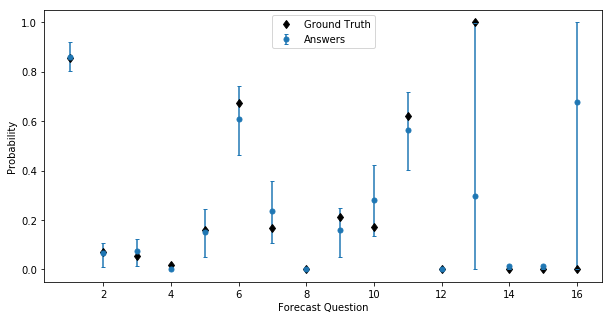

In [23]:
gt = np.genfromtxt('RCP12results.csv', delimiter = ',')
plt.figure(figsize=(10,5))
a_err = [answers[1,:]-answers[2,:],answers[0,:]-answers[1,:]]
plt.plot(np.arange(1,17,1), gt[:,2], ls = '', marker = 'd', color = 'k', label = 'Ground Truth')
plt.errorbar(np.arange(1,17,1), answers[1,:], yerr = a_err,
             fmt='o', markersize = 5, capsize=2, label = 'Answers')
plt.xlabel('Forecast Question')
plt.ylabel('Probability')
plt.legend()
plt.show()

Finally, let's score our forecasts against ground truth:

In [24]:
def scoring(t, a):
	y = np.zeros(3)
	CIC = 0
	ISR = 0
	y[0] = ((t - a[1,:])**2).mean()
	for i in range(len(t)):
		if a[0,i] > t[i] and a[2,i] < t[i]:
			CIC = CIC + 1
		ISR = ISR + (a[0,i] - a[2,i]) + 5*(t[i] - a[0,i])*(t[i] > a[0,i]).astype('float') + 5*(a[2,i] - t[i])*(a[2,i] > t[i]).astype('float')
		
	y[1] = 1/len(t)*CIC
	y[2] = 1/len(t)*ISR
	
	return y

In [25]:
q = scoring(gt[:,2],answers)
print('MSE: ' + str(q[0]))
print('CIC: ' + str(q[1]))
print('ISR: ' + str(q[2]))

MSE: 0.0613660113964
CIC: 0.5625
ISR: 0.246542301519
